# Paralelni algoritmi - Drugi projekat

- Projekat se radi individualno ili u paru

- Rok za predaju projekata je **sreda 21.12.2022, do kraja dana (23:59)**. 

- Odbrane će biti organizovane u toku kolokvijumske nedelje.

- Predaja projekata je putem e-maila, programski kod bi trebalo da
bude prikacen uz sam e-mail. Subject e-maila treba da bude u formatu
"[RN3RA Projekat 1] Prezime (Prezime ukoliko se radi u paru)". Tekst e-maila treba da bude u formi:
"Ime Prezime XX/GGRN" (gde su XX i GG broje indeksa i godina upisa).
Link ka Collab-u je opcion. Ukoliko dva
studenta rade u paru, dovoljno je da jedan od njih preda, pri cemu
drugog stavi u cc.

# Uvod 
Ekspresiju gena možemo meriti tako što u uzorku tkiva izmerimo količinu RNK molekula poteklu sa transkripata tog gena (više informacija na ovu temu će biti obrađeno u okviru predmeta Uvod u bioinformatiku u sledećem semetru; za potrebe ovog kursa dovoljno je da ekspresije posmatramo kao matrice brojeva).  

SC RNA-seq je tehnologija koja nam omogućava da merimo ekspresije gena na nivou pojedinačnih ćelija u uzorku. Dakle, podaci sa kojima radimo je matrica čiji redovi označavaju različite gene, kolone različite ćelije iz uzorka, a vrednosti predstavljaju ekspresiju datog gena u datoj ćeliji.

U okviru ovog projekta ćete implementirati standardne korake pri obradi SC RNA-seq podataka, ali koristeći map/reduce pristup.  

Uobičajen način razmišljanja o SC RNA-seq podacima je da ih posmatramo kao podakte o skupu ćelija, pri čemu je svaka ćelija jedna (multidimenzionalna) tačka predstavljenom vektorom genskih ekspresija izmerenih za tu ćeliju. 
- Često želimo da pronađemo grupe (klastere) ćelija, gde su ćelije sličnih ekspresija svrstane u istu grupu
- Često je korisno podatke prikazati u 2D (kako bi mogli da vidimo grupe), i za to se uglvnom koriste tehnike redukcije dimenzionalnosti kao što su TSNE ili UMAP. Detalji ovih metoda prevazilaze okvire ovog kursa, pa su je projekat dati i UMAP istog skupa podataka koji obrađujemo u okviru projekta.

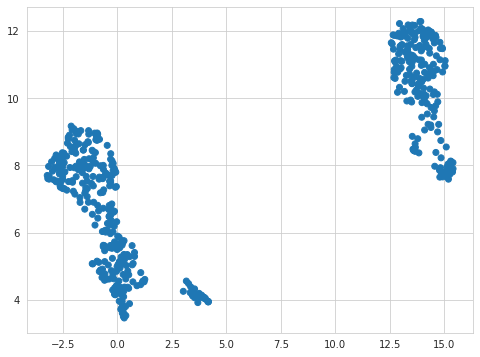

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn


df = pd.read_table('ekspresije.tsv', index_col=0)
data = [(cell, gene, value) for cell in df.columns 
                            for gene, value in df[cell].iteritems()]

embedding = pd.read_table('umap.tsv')
embedding['cluster'] = 0
plt.figure(figsize=(8, 6))
plt.scatter(
    embedding.umap1,
    embedding.umap2,
    c=[sn.color_palette()[x] for x in embedding.cluster]
)

# Zadatak

Data je matrice geneteskih ekspresija dobijenih SC RNA-seq tehnologijom. Potrebno je napisati kod koji radi sledecu obradu.

Matricu možete učitati u format pogodan za dalju obradu slecećim kodom:

```python
import pandas as pd
df = pd.read_table('ekspresije.tsv', index_col=0)
data = [(cell, gene, value) for cell in df.columns 
                            for gene, value in df[cell].iteritems()]
```
Uz matricu vrednosti je data i matrica UMAP vrednosti za svaku ćeliju. UMAP možete učitati i nacrtati sledećim kodom:
```python
import matplotlib.pyplot as plt
import seaborn as sn

embedding = pd.read_table('umap.tsv')
embedding['cluster'] = 0
plt.figure(figsize=(8, 6))
plt.scatter(
    embedding.umap1,
    embedding.umap2,
    c=[sn.color_palette()[x] for x in embedding.cluster]
)
```
U sklopu zataka će biti potrebni odrediti klastere kojima ćelije pripadaju, pa će linija:
```python
embedding['cluster'] = 0
```
Biti zamenjena linijom koja upisu izračunate klastere. Na primer, ako imamo map oblika `klasteri = {'cell_id': 'cluster_id'}`:
```python
embedding['cluster'] = embedding.cell.map(klasteri)
```

#  1. Normalizacija unutar ćelija

- (1.1) Pomoću funkcije reduce odrediti srednju vrednost eksresija gena unutar svake ćelije.  
  Rezultat formirati kao niz tuple-ova (ćelija, srednja-vrednost). Poslednji element rezultata možete izmeniti nakon poziva funkcije reduce. **(1.5 bod)**

- (1.2) Pomoću funkcije map izrvšiti centriranje vrednosti ekspresija oko srednje vrednosti unutar date ćelije.   
  Rezultat treba da bude niz tuple-ova (ćelija, gen, vrednost - srednja-vrednost-u-ćeliji).   
  Radi rešavanja ove tačke niz srednjih vrednosti iz prethodne tačke možete pretvoriti u mapu (dict). **(1 bod)**

- (1.3) Pomoću funkije reduce odrediti odrediti varijansu ekspresija unutar svake ćelije, polazeći od rezultata iz prethodnog koraka.  
Rezultat treba da bude niz tuple-ova (ćelija, varijansa-vrednosti-u-ćeliji). Poslednji element rezultata možete izmeniti nakon poziva funkcije reduce. **(1 bod)**

- (1.4) Pomoću funkcije map odrediti standardnu devijaciju ekspresija unutar svake ćelije, polazeći od niza varijansi iz tačke (1.3). Rezultat formirati kao niz tuple-ova (ćelija, standardna devijacija). **(0.5 bodova)**

- (1.5) Pomoću funkcije map izrvšiti izvršiti stadnardizaciju vrednosti ekspresija unutar svake ćelije, polazeći od niza iz u tačke (1.2). Rezultat treba da bude niz tuple-ova (ćelija, gen, vrednost). Radi rešavanja ove tačke, rezultat  tačke (1.4) možete pretvoriti u mapu (dict). **(1 bod)**


### Defnicije operacija
- Centriranje vrednosti ekspresija oko srednje vrednosti niza: oduzimanje srednje vrednosti niza od svih elemenata niza
- Stadnardizacija vrednosti niza $z = \frac{x - x_{srednje}}{\sigma}$, pri čemu je $x_{srednje}$ srednja vrednost niza, a $\sigma$ standardna devijacija.

# 2. Nomralizacija vrednosti ekspresije gena

- (2.1) Pomoću funkija `map` i `reduce` odrediti varijansu ekspresija za svaki gen. Kao ulaz koristi niz kreiran u stavci (1.5), koji prethodno mozete sortirati po imenu gena. Možete primeniti istu skevencu koraka kao u tačkama 1.1-1.3 (računanje srednjih vrednosti, centriranje, pa varijansa).
Rezultat treba da bude niz tuple-ova (gen, varijansa-vrednosti-gena). Poslednji element rezultata možete izmeniti nakon poziva funkcije reduce. **1 bod**

- (2.2) Pomoću funckije `reduce` odrediti skup od 500 najvarijabilnijh gena. Kao ulaz koristi niz kreiran u stavci (2.1), koji možete prethodno sortirati standardnim metodama. **1 bod**

- (2.3) Pomoću funkcije `reduce` filtirati niz iz tačke (1.5) tako da sadrži samo gene koji se nalaze u 500 najvarijabilnijih gena. **1 bod**

- (2.4) Sortirati niz kreiran u zadatku (2.3), tako da bude leksikografki sortiran po imenu gena (sve vrednosti izmerene za isti gen će se tako naći jedna do druge), a unutar jednog gena **rastući** po vrednosti normalizovane ekspresije.  
Rezultat treba da bude niz tuple-ova (ćelija, gen, vrednost).  
U okviru ove tačke možete koristi python funkciju `sorted`. 

- (2.5) Pomoću funkcije `reduce` izvršiti rank normalizaciju vrednosti unutar jednog gena (najmanja izmerena vrednost gena u bilo kojoj ćeliji će dobiti vrednost 1, sledeća 2 itd. Ako je za neki gen izmerena ista vrednost u dve ćelije, rang će biti ponovljen).  
Rezultat treba da bude niz tuple-ova (ćelija, gen, originalna-vrednost, rank-vrednost): **1.5 bod**

- (2.6) Pomoću funkcije map izbaciti originalne vrednosti (pre rank normalizacije) iz niza iz tačke 2.2. **0.5 bodova**

# 3. K-means klasterovanje

- (3.1) Pomoću funkcije reduce grupisati vrednosti iz niza iz tačke (2.5) prema ćeliji.  
Rezultat treba da bude niz čiji su elementi tuple-ovi, takvi da je prvi element tuple-a identifikator ćelije, a drugi element niz vrednosti za sve gene izmerene u toj ćeliji.  
Vrednosti za različite gene moraju da se pojavljuju istim redosledom kod svih ćelija.: **2 boda**

- (3.2) Pomoću funkcija map i reduce implementriati k-means klasterovanje.  Klasterovati podatke u 2, 4, 6 i 10 klastera i prikazati rezultate bojenjem UMAP grafikona (UMAP kooridnate su date u posebnom fajlu).  
Nacrtati UMAP grafikone posle 1, 10 i 250 iteracija optimizacije **8 bodova**